In [1]:
import pandas as pd
import numpy as np
import re
import string
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors
from keras.activations import relu
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Embedding, Flatten, Conv1D, MaxPooling1D
from keras.layers import Dropout, concatenate
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [2]:
snippet_file  = 'original_rt_snippets.txt'
positive_file = 'rt-polarity_pos.pos'
negative_file = 'rt-polarity_neg.neg'
sentences_for_data = pd.read_csv('datasetSentences.txt',sep = "\t",header = 0)
splitdata = pd.read_csv('datasetSplit.txt', delimiter = ",", header = 0)

In [3]:
snippet_file_list = []
filesnippet = open("original_snipp.txt","w+")
filesnippet.seek(0)
filesnippet.truncate()
with open(snippet_file, 'rt', encoding = 'latin-1') as f:
    for each_line in f:
        each_line = each_line.lower()                     
        each_line = re.sub('<.*?>', '',each_line) 
        each_line = re.sub('<[a-zA-Z]','',each_line)      
        each_line = re.sub(r'[^\w]','',each_line)         
        each_line = re.sub(r'[0-9]','',each_line)
        each_line = re.sub(r'[^\x00-\x7f]','',each_line)  
        snippet_file_list.append(each_line)
        filesnippet.write(each_line+"\n")
filesnippet.close()

In [4]:
positivefile=[]
fileforpositive = open("Positive_Labels.txt","w+")
fileforpositive.seek(0)
fileforpositive.truncate()
with open(positive_file,'rt',encoding='latin-1') as f:
    for each_line in f:
        each_line = each_line.lower()                     
        each_line = re.sub('<.*?>', '',each_line)         
        each_line = re.sub('<[a-zA-Z]','',each_line)      
        each_line = re.sub(r'[^\w]','',each_line)
        each_line = re.sub(r'[0-9]','',each_line)         
        each_line = re.sub(r'[^\x00-\x7f]','',each_line)  # removes non ascii characters
        positivefile.append(each_line)
        fileforpositive.write(each_line+"\n")
fileforpositive.close()

In [5]:
negativefile=[]
filefornegative = open("negative_labels.txt","w+")
filefornegative.seek(0)
filefornegative.truncate()
with open(negative_file,'rt',encoding='latin-1') as f:
    for each_line in f:
        each_line = each_line.lower()
        each_line = re.sub('<.*?>', '',each_line)
        each_line = re.sub('<[a-zA-Z]','',each_line)        
        each_line = re.sub(r'[^\w]','',each_line)
        each_line = re.sub(r'[0-9]','',each_line)
        each_line = re.sub(r'[^\x00-\x7f]','',each_line)
        negativefile.append(each_line)
        filefornegative.write(each_line+"\n")
filefornegative.close()

In [6]:
labels_for_test = []
for line in snippet_file_list:
    if any(line == text for text in positivefile):
        labels_for_test.append(1)
    elif any(line == text for text in negativefile):
        labels_for_test.append(0)
    #Through by lot of preprocessing process we get to know that there is one sentence which doesn't belong to any of the files 
    elif line =="ihavenoproblemwithdifficultmoviesormoviesthatasktheaudiencetomeetthemhalfwayandconnectthedotsinsteadofhavingthingsallspelledoutbutfirstyouhavetogivetheaudienceareasontowanttoputforthateffort" :
        labels_for_test.append(0)
    else:
        print (line )

In [7]:
def IndexPositionWithOriginalFile(each_sentence, original_snippet_sentences):
    for indexposition in range(len(original_snippet_sentences)):
        if each_sentence in original_snippet_sentences[indexposition]:
            return indexposition 

In [8]:
def filtering_sentence(each_sentence):
    each_sentence= each_sentence.lower()
    each_sentence = re.sub(r'[^\w]','',each_sentence)
    each_sentence = re.sub(r'[0-9]','',each_sentence)
    each_sentence = re.sub(r'[^\x00-\x7f]','',each_sentence)
    each_sentence = each_sentence.replace("lrb", "")
    each_sentence = each_sentence.replace("rrb","")
    return each_sentence


In [9]:
labels=[]
filefordataset = open("dataset.txt","w+")
for each_sentence in list(sentences_for_data["sentence"].values):
    each_sentence= filtering_sentence(each_sentence)
    filefordataset.write(each_sentence+"\n")
    index = IndexPositionWithOriginalFile(each_sentence,snippet_file_list)
    labels.append(labels_for_test[index])
    snippet_file_list[index]= snippet_file_list[index].replace(each_sentence,"$$",1)  # Removes the sentence that has been matched already to avoid confusion and match with the correct original_snippet when same set of characters appear again.
filefordataset.close()
sentences_for_data["labels"]=labels

In [10]:
sentences_for_data['labels']

0        1
1        1
2        1
3        1
4        1
        ..
11850    0
11851    0
11852    1
11853    0
11854    0
Name: labels, Length: 11855, dtype: int64

In [11]:
len(splitdata)

11855

In [12]:
len(sentences_for_data)

11855

# Creating Word Embeddings

In [13]:
#Inserting all the texts into list
listoftexts,listwords=[],[]
for line in sentences_for_data['sentence']:
        exclude = set(string.punctuation)
        line = ''.join(ch for ch in line if ch not in exclude)
        listwords=[]
        for word in line.split():
            listwords.append(word)
        listoftexts.append(listwords)

In [14]:
#Arranging train_indexes,test_indexes and dev_indexes to split the data accordingly
train_indexes,test_indexes,dev_indexes=[],[],[]
for k,i in enumerate(splitdata['splitset_label']):
    if i==1:
        train_indexes.append(k+1)
    if i==2:
        test_indexes.append(k+1)
    if i==3:
        dev_indexes.append(k+1)


In [15]:
#Inserting all labels into one list
all_labels=[]
for i in sentences_for_data['labels']:
    all_labels.append(i)  

In [16]:
#Inserting all the class labels into different indexes accordingly
y_train,y_dev,y_test=[],[],[]
for i in train_indexes:
    y_train.append(all_labels[i-1])
for i in dev_indexes:
    y_dev.append(all_labels[i-1])
for i in test_indexes:
    y_test.append(all_labels[i-1])

In [17]:
#Splitting each text into tokens and padding corrrespondingly
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(listoftexts)
sequences = tokenizer.texts_to_sequences(listoftexts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences)

Found 19377 unique tokens.


In [18]:
#Arranging the data which were padded according to Train,test and Dev
X_train,X_dev,X_test=[],[],[]
for i in train_indexes:
    X_train.append(list(data[i-1]))
for i in dev_indexes:
    X_dev.append(list(data[i-1]))
for i in test_indexes:
    X_test.append(list(data[i-1]))

In [19]:
#Creating the embeddings Index to create embeddings matrix
embeddings_index = {}
f = open(r'C:\Users\srika\OneDrive\Desktop\Fall19\DeepLearningForNLP\Assignment2\glove.6B.300d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [20]:
#Forming Embedding Matrix
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


In [21]:
#Creating the embedding layer
from keras.layers import Embedding
def get_embeddings_layer(embeddings_matrix, name, max_len, trainable=False):
    embedding_layer = Embedding(
        input_dim=embeddings_matrix.shape[0],
        output_dim=embeddings_matrix.shape[1],
        input_length=max_len,
        weights=[embeddings_matrix],
        trainable=trainable,
        name=name)
    return embedding_layer

In [22]:
def get_conv_pool(x_input, max_len, sufix, n_grams=[3,4,5], feature_maps=100):
    branches = []
    for n in n_grams:
        branch = Conv1D(filters=feature_maps, kernel_size=n, activation=relu, name='Conv_'+sufix+'_'+str(n))(x_input)
        branch = MaxPooling1D(pool_size=max_len-n+1, strides=None, padding='valid', name='MaxPooling_'+sufix+'_'+str(n))(branch)
        branch = Flatten(name='Flatten_'+sufix+'_'+str(n))(branch)
        branches.append(branch)
    return branches

# CNN_rand: All words were randomly initialized and then modified during training


In [23]:
def get_cnn_rand(embedding_dim=300, vocab_size=(len(word_index)+1), max_len=52):
    # create the embedding layer
    embedding_matrix_cnn_rand = np.random.rand(vocab_size, embedding_dim)
    embedding_layer = get_embeddings_layer(embedding_matrix_cnn_rand, 'embedding_layer_dynamic', max_len, trainable=True)

    # connect the input with the embedding layer
    i = Input(shape=(max_len,), dtype='int32', name='main_input')
    x = embedding_layer(i)

    # generate several branches in the network, each for a different convolution+pooling operation,
    # and concatenate the result of each branch into a single vector
    branches = get_conv_pool(x, max_len, 'dynamic')
    z = concatenate(branches, axis=-1)
    z = Dropout(0.5)(z)

    # pass the concatenated vector to the predition layer
    o = Dense(1, activation='sigmoid', name='output')(z)

    model = Model(inputs=i, outputs=o)
    model.compile(loss={'output': 'binary_crossentropy'}, optimizer='adam',metrics=["accuracy"])

    return model

In [24]:
model_cnn_rand=get_cnn_rand()

In [25]:
history=model_cnn_rand.fit(np.array(X_train),np.array(y_train),batch_size=1024,epochs=10,validation_data=(np.array(X_dev),np.array(y_dev)))

C:\Python37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8544 samples, validate on 1101 samples
Epoch 1/10
8544/8544 [==============================] - 7s 863us/step - loss: 1.8519 - accuracy: 0.5030 - val_loss: 1.5371 - val_accuracy: 0.5050
Epoch 2/10
8544/8544 [==============================] - 7s 803us/step - loss: 1.0755 - accuracy: 0.4998 - val_loss: 0.9768 - val_accuracy: 0.5050
Epoch 3/10
8544/8544 [==============================] - 7s 804us/step - loss: 0.8518 - accuracy: 0.5137 - val_loss: 0.7166 - val_accuracy: 0.5050
Epoch 4/10
8544/8544 [==============================] - 7s 815us/step - loss: 0.7435 - accuracy: 0.5273 - val_loss: 0.6855 - val_accuracy: 0.5395
Epoch 5/10
8544/8544 [==============================] - 7s 842us/step - loss: 0.6813 - accuracy: 0.5741 - val_loss: 0.6887 - val_accuracy: 0.5168
Epoch 6/10
8544/8544 [==============================] - 8s 879us/step - loss: 0.6669 - accuracy: 0.5905 - val_loss: 0.6764 - val_accuracy: 0.6031
Epoch 7/10
8544/8544 [==============================] - 11s 1ms/step - loss:

In [26]:
hist = pd.DataFrame(history.history)
hist

,val_loss,val_accuracy,loss,accuracy
0,1.537074,0.504995,1.851905,0.503043
1,0.976781,0.504995,1.075509,0.499766
2,0.716588,0.504995,0.851807,0.513694
3,0.685511,0.539510,0.743455,0.527271
4,0.688650,0.516803,0.681260,0.574087
5,0.676416,0.603088,0.666890,0.590473
6,0.678265,0.559491,0.651406,0.636353
7,0.684006,0.524977,0.639292,0.657420
8,0.670856,0.599455,0.631819,0.662804
9,0.668891,0.583106,0.615840,0.704003


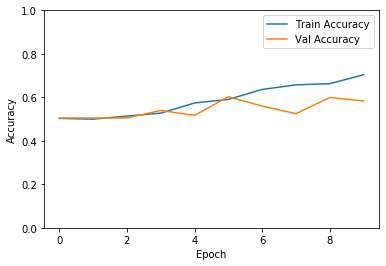

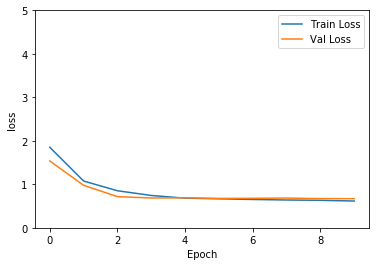

In [27]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
def plot_history(history):
    
      hist = pd.DataFrame(history.history)
      hist['epoch'] = history.epoch

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.plot(hist['epoch'], hist['accuracy'],
               label='Train Accuracy')
      plt.plot(hist['epoch'], hist['val_accuracy'],
               label = 'Val Accuracy')
      plt.ylim([0,1])
      plt.legend()

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('loss')
      plt.plot(hist['epoch'], hist['loss'],
               label='Train Loss')
      plt.plot(hist['epoch'], hist['val_loss'],
               label = 'Val Loss')
      plt.ylim([0,5])
      plt.legend()

      plt.show()
plot_history(history)



In the above model by tuning all the hyper parameters I get to know batch size plays a key role among all others because when I have taken smaller batch size the validaion accuracy is around 65 but when i increase the batch size and want to train the modeL.The training accuracy as well as validation accuracy gets increased.This is due to smaller batch sizes not only has faster training dynamics but also generalization to the test dataset versus larger batch sizes.

# CNN-Static:Pre-trained vectors with all the words including the unknown ones that are randomly initialized-kept static and only the other parameters of the model are learned

In [28]:
embedding_layer = get_embeddings_layer(embedding_matrix, 'embedding_layer_static', 52, trainable=False)

In [29]:
def get_cnn_pre_trained_embeddings(embedding_layer, max_len):
    # connect the input with the embedding layer
    i = Input(shape=(max_len,), dtype='int32', name='main_input')
    x = embedding_layer(i)

    # generate several branches in the network, each for a different convolution+pooling operation,
    # and concatenate the result of each branch into a single vector
    branches = get_conv_pool(x, max_len, 'static')
    z = concatenate(branches, axis=-1)

    # pass the concatenated vector to the predition layer
    o = Dense(1, activation='sigmoid', name='output')(z)

    model = Model(inputs=i, outputs=o)
    model.compile(loss={'output': 'binary_crossentropy'}, optimizer='adam',metrics=["accuracy"])

    return model

In [30]:
model_cnn_static = get_cnn_pre_trained_embeddings(embedding_layer, 52)

In [31]:
history=model_cnn_static.fit(np.array(X_train),np.array(y_train),batch_size=1024,epochs=5,validation_data=(np.array(X_dev),np.array(y_dev)))

Train on 8544 samples, validate on 1101 samples
Epoch 1/5
8544/8544 [==============================] - 5s 620us/step - loss: 0.7088 - accuracy: 0.5756 - val_loss: 0.6116 - val_accuracy: 0.6403
Epoch 2/5
8544/8544 [==============================] - 5s 613us/step - loss: 0.5462 - accuracy: 0.7252 - val_loss: 0.5481 - val_accuracy: 0.7103
Epoch 3/5
8544/8544 [==============================] - 5s 616us/step - loss: 0.4823 - accuracy: 0.7759 - val_loss: 0.5198 - val_accuracy: 0.7430
Epoch 4/5
8544/8544 [==============================] - 5s 618us/step - loss: 0.4361 - accuracy: 0.8117 - val_loss: 0.5012 - val_accuracy: 0.7584
Epoch 5/5
8544/8544 [==============================] - 5s 611us/step - loss: 0.4002 - accuracy: 0.8408 - val_loss: 0.4961 - val_accuracy: 0.7584


In [32]:
hist = pd.DataFrame(history.history)
hist

,val_loss,val_accuracy,loss,accuracy
0,0.611639,0.640327,0.708806,0.575609
1,0.548053,0.710263,0.546235,0.725187
2,0.519824,0.742961,0.482284,0.775866
3,0.501202,0.758401,0.436083,0.811681
4,0.496077,0.758401,0.400203,0.840824


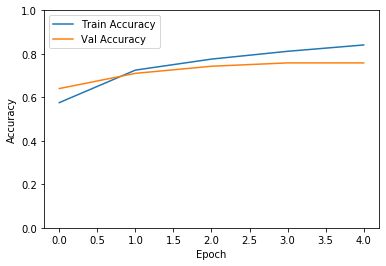

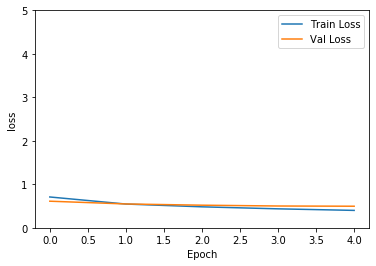

In [33]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
def plot_history(history):
    
      hist = pd.DataFrame(history.history)
      hist['epoch'] = history.epoch

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.plot(hist['epoch'], hist['accuracy'],
               label='Train Accuracy')
      plt.plot(hist['epoch'], hist['val_accuracy'],
               label = 'Val Accuracy')
      plt.ylim([0,1])
      plt.legend()

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('loss')
      plt.plot(hist['epoch'], hist['loss'],
               label='Train Loss')
      plt.plot(hist['epoch'], hist['val_loss'],
               label = 'Val Loss')
      plt.ylim([0,5])
      plt.legend()

      plt.show()
plot_history(history)



In this model the word embeddings actually uses glove word embeddings through that they wont get trained because we were giving trainable as false. So they won't get trained in the initial stage when we check in the below layers all will be mentioned as static. When we check for the accuracy how good they are there isn't much change that i have observed when i changed n_grams or kernel size but changing batch_size changes a lot.

# CNN_Non_Static:In this model the word vectors will get trained

In [34]:
embedding_layer_cnn_nonstatic = get_embeddings_layer(embedding_matrix, 'embedding_layer_dynamic', 52, trainable=True)
model_cnn_non_static = get_cnn_pre_trained_embeddings(embedding_layer_cnn_nonstatic, 52)

In [35]:
history=model_cnn_non_static.fit(np.array(X_train),np.array(y_train),batch_size=1024,epochs=5,validation_data=(np.array(X_dev),np.array(y_dev)))

C:\Python37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8544 samples, validate on 1101 samples
Epoch 1/5
8544/8544 [==============================] - 7s 862us/step - loss: 0.7123 - accuracy: 0.5689 - val_loss: 0.6297 - val_accuracy: 0.6176
Epoch 2/5
8544/8544 [==============================] - 7s 861us/step - loss: 0.5358 - accuracy: 0.7355 - val_loss: 0.5516 - val_accuracy: 0.7094
Epoch 3/5
8544/8544 [==============================] - 7s 852us/step - loss: 0.4482 - accuracy: 0.8050 - val_loss: 0.5121 - val_accuracy: 0.7475
Epoch 4/5
8544/8544 [==============================] - 7s 860us/step - loss: 0.3825 - accuracy: 0.8565 - val_loss: 0.4954 - val_accuracy: 0.7611
Epoch 5/5
8544/8544 [==============================] - 7s 870us/step - loss: 0.3307 - accuracy: 0.8878 - val_loss: 0.4862 - val_accuracy: 0.7711


In [36]:
hist = pd.DataFrame(history.history)
hist

,val_loss,val_accuracy,loss,accuracy
0,0.629749,0.617620,0.712251,0.568937
1,0.551643,0.709355,0.535763,0.735487
2,0.512134,0.747502,0.448224,0.805009
3,0.495378,0.761126,0.382473,0.856507
4,0.486238,0.771117,0.330732,0.887757


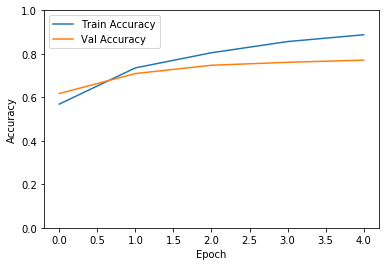

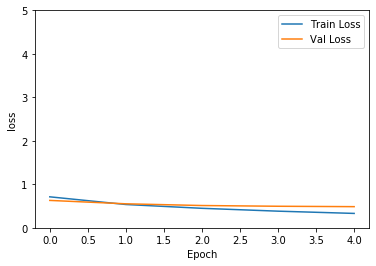

In [37]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
def plot_history(history):
    
      hist = pd.DataFrame(history.history)
      hist['epoch'] = history.epoch

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.plot(hist['epoch'], hist['accuracy'],
               label='Train Accuracy')
      plt.plot(hist['epoch'], hist['val_accuracy'],
               label = 'Val Accuracy')
      plt.ylim([0,1])
      plt.legend()

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('loss')
      plt.plot(hist['epoch'], hist['loss'],
               label='Train Loss')
      plt.plot(hist['epoch'], hist['val_loss'],
               label = 'Val Loss')
      plt.ylim([0,5])
      plt.legend()

      plt.show()
plot_history(history)



In the above model in the embedding layer we will change it to dynamic layer by giving trainable as True so that these word embeddings weights get updated and below layers will be in normal form in static stage.when we check for the accuracy in both the figure's in static and non_static they are almost equal these figure's also they do have lot of sensitivity with batch_size

# Best Model

Among the three models, CNN-non static is the best model because the pre-trained vectors are fine tuned for each task and through by validation accuracy is like very high among all the three that is almost 78. So I consider CNN-non static is the best model.

# Computing Metrics

In [46]:
y_pred=model_cnn_non_static.predict(np.array(X_test),verbose=1)

2210/2210 [==============================] - 1s 374us/step


In [57]:
# convert raw predictions to class indexes
threshold = 0.5
class_predictions = [(x > threshold).astype(int) for x in y_pred]

# convert back to original class names
pred_classes =np.array(class_predictions)

# print precision, recall, f1-score report
print(classification_report(y_test, pred_classes))

              precision    recall  f1-score   support

           0       0.81      0.75      0.78      1138
           1       0.75      0.81      0.78      1072

    accuracy                           0.78      2210
   macro avg       0.78      0.78      0.78      2210
weighted avg       0.78      0.78      0.78      2210



Almost all the values are similar like F-score,Recall_score and Precision Score
->F-score is basically calculated to seek a balance between precision and recall and when when there is an uneven class of distribution. 
->As we can see the F score measure also high so we can say that it works fine 
->In precision the denominator counts total predicted positive so by this we can say how accuarate our model is in all the three models comparitively Precision is higher ->Recall also playes a key role by saying how many positives our model calculated. 
->In all the three models GRU model comapritively performs better as we can say that by checking the above metrics.

# Observation from 3 models

Through by tuning different hyper-parameters those are batch_size, drop rate it changes with different models basically applying convolution layer with multiple filter widths and feature maps then after applying max_over_time pooling operation over the feature map. Concatenate feature results from different layers and feed to a fully connected layer with softmax activation and used dropout for regularization. All the above mentioned process is same in all layers except few changes adding embedding layer.In CNN_rand by tuning all the hyper parameters I get to know batch size plays a key role among all others because when I have taken smaller batch size the validaion accuracy is around 65 but when i increase the batch size and want to train the modeL.The training accuracy as well as validation accuracy gets increased.This is due to smaller batch sizes not only has faster training dynamics but also generalization to the test dataset versus larger batch sizes where as in CNN_Static the word embeddings actually uses glove word embeddings through that they wont get trained because we were giving trainable as false. So they won't get trained in the initial stage when we check in the below layers all will be mentioned as static. When we check for the accuracy how good they are there isn't much change that i have observed when i changed n_grams or kernel size but changing batch_size changes a lot.In CNN_non static in the embedding layer we will change it to dynamic layer by giving trainable as True so that these word embeddings weights get updated and below layers will be in normal form in static stage.when we check for the accuracy in both the figure's in static and non_static they are almost equal these figure's also they do have lot of sensitivity with batch_size

